In [ ]:
%matplotlib inline


# Comparing different clustering algorithms on toy datasets


This example shows characteristics of different
clustering algorithms on datasets that are "interesting"
but still in 2D. With the exception of the last dataset,
the parameters of each of these dataset-algorithm pairs
has been tuned to produce good clustering results. Some
algorithms are more sensitive to parameter values than
others.

The last dataset is an example of a 'null' situation for
clustering: the data is homogeneous, and there is no good
clustering. For this example, the null dataset uses the
same parameters as the dataset in the row above it, which
represents a mismatch in the parameter values and the
data structure.

While these examples give some intuition about the
algorithms, this intuition might not apply to very high
dimensional data.


Automatically created module for IPython interactive environment


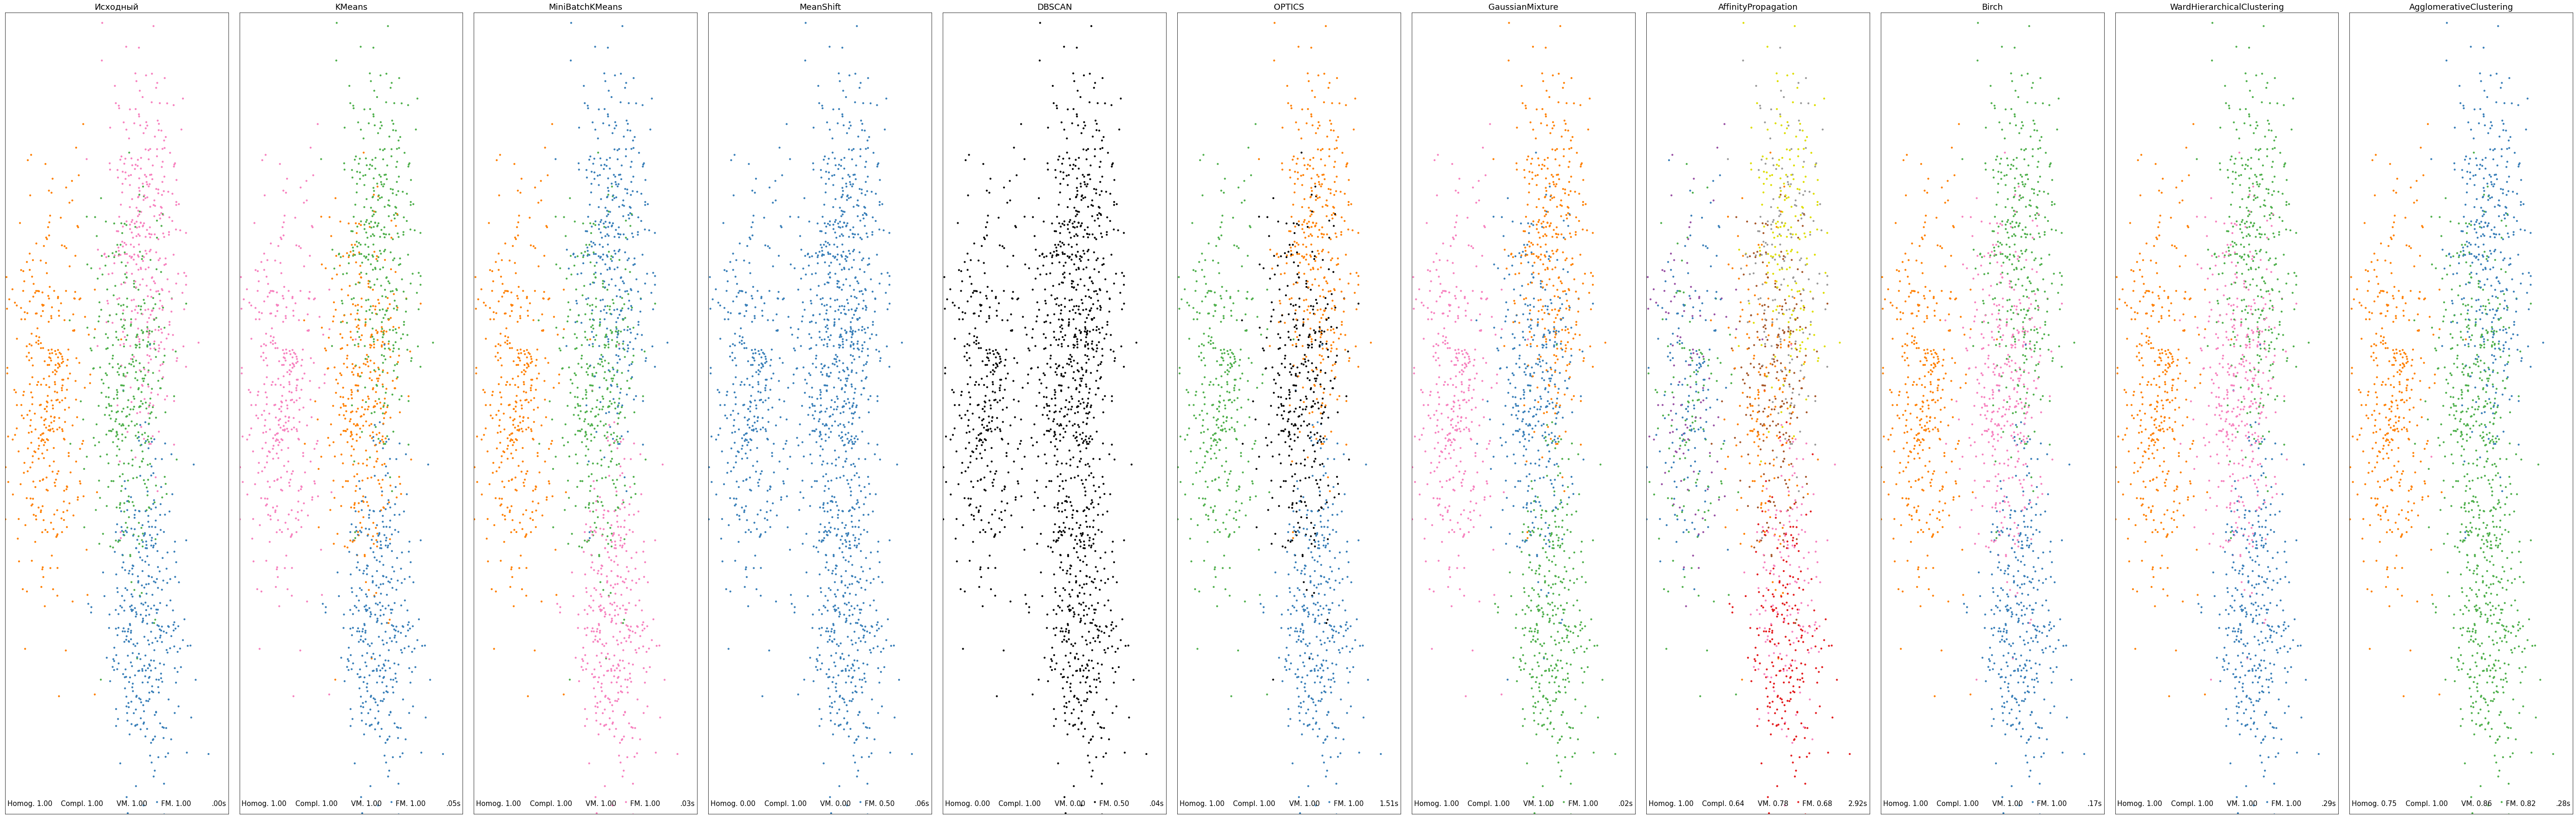

In [40]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics.cluster import fowlkes_mallows_score

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
r_s = 6
X, y_train = datasets.make_blobs(n_samples=n_samples, random_state=r_s,
                                          centers=4, cluster_std=.1,
                                          center_box=(-1000,1000))
blobs_strong_linear = datasets.make_blobs(n_samples=n_samples, random_state=r_s,
                                          centers=4, cluster_std=.1,
                                          center_box=(-1000,1000))
blobs_not_strong_linear = datasets.make_blobs(n_samples=n_samples, random_state=r_s,
                                          centers=4, cluster_std=.1,
                                          center_box=(-.8,.8))
blobs_not_linear_10_20 = datasets.make_blobs(n_samples=n_samples, random_state=r_s,
                                          centers=4, cluster_std=.1,
                                          center_box=(-.4,.4))
blobs_not_linear_50_70 = datasets.make_blobs(n_samples=n_samples, random_state=r_s,
                                          centers=4, cluster_std=.1,
                                          center_box=(-.3,.3))
blobs_not_strong_linear_7 = datasets.make_blobs(n_samples=n_samples, random_state=r_s,
                                          centers=4, cluster_std=.1,
                                          center_box=(-.3,.3), n_features=20)
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(80, 25))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    # (blobs_strong_linear, {'n_clusters': 4}),
    # (blobs_not_strong_linear, {'n_clusters': 4}),
    # (blobs_not_linear_10_20, {'n_clusters': 4}),
    # (blobs_not_linear_50_70, {'n_clusters': 4}),
    (blobs_not_strong_linear_7, {'n_clusters': 4}),
    # (noisy_circles, {'damping': .77, 'preference': -240,
    #                  'quantile': .2, 'n_clusters': 2,
    #                  'min_samples': 20, 'xi': 0.25}),
    # (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    # (varied, {'eps': .18, 'n_neighbors': 2,
    #           'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    # (aniso, {'eps': .15, 'n_neighbors': 2,
    #          'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    # (blobs, {}),
    # (no_structure, {})
    ]
scoress = []
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    kmeans = cluster.KMeans(n_clusters = params['n_clusters'])
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('Исходный', 0),
        # K-means
        ('KMeans', kmeans),
        # неиерарх
        ('MiniBatchKMeans', two_means),
        ('MeanShift', ms),
        ('DBSCAN', dbscan), # non
        ('OPTICS', optics), # non
        ('GaussianMixture', gmm), # non
        # иерарх
        ('AffinityPropagation', affinity_propagation),
        ('Birch', birch),
        ('WardHierarchicalClustering', ward),
        ('AgglomerativeClustering', average_linkage),
    )

    scores = dict()

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            if name!='Исходный': algorithm.fit(X)

        t1 = time.time()
        if name=='Исходный':
          y_pred = y
        elif hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        Homogeneity  = homogeneity_score(y, y_pred)
        Completeness = completeness_score(y, y_pred)
        Vmeasure = v_measure_score(y, y_pred)
        Mallows = fowlkes_mallows_score(y, y_pred)
        scores['Homogeneity__'+name+'__dataset'+str(i_dataset)] = '%.3f' % Homogeneity
        scores['Completeness__'+name+'__dataset'+str(i_dataset)] = '%.3f' % Completeness
        scores['Vmeasure__'+name+'__dataset'+str(i_dataset)] = '%.3f' % Vmeasure
        scores['FowlkesMallows__'+name+'__dataset'+str(i_dataset)] = '%.3f' % Mallows

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plt.text(.01, .01, 'Homog. %.2f' % Homogeneity,
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='left')
        plt.text(.25, .01, 'Compl. %.2f' % Completeness,
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='left')
        plt.text(.5, .01, 'VM. %.2f' % Vmeasure,
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='left')
        plt.text(.7, .01, 'FM. %.2f' % Mallows,
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='left')
        plot_num += 1

    scoress.append(scores)
    if i_dataset>5: break

plt.show()

In [41]:
scoress

[{'Completeness__AffinityPropagation__dataset0': '0.639',
  'Completeness__AgglomerativeClustering__dataset0': '0.996',
  'Completeness__Birch__dataset0': '1.000',
  'Completeness__DBSCAN__dataset0': '1.000',
  'Completeness__GaussianMixture__dataset0': '1.000',
  'Completeness__KMeans__dataset0': '1.000',
  'Completeness__MeanShift__dataset0': '1.000',
  'Completeness__MiniBatchKMeans__dataset0': '1.000',
  'Completeness__OPTICS__dataset0': '0.997',
  'Completeness__WardHierarchicalClustering__dataset0': '1.000',
  'Completeness__Исходный__dataset0': '1.000',
  'FowlkesMallows__AffinityPropagation__dataset0': '0.684',
  'FowlkesMallows__AgglomerativeClustering__dataset0': '0.816',
  'FowlkesMallows__Birch__dataset0': '1.000',
  'FowlkesMallows__DBSCAN__dataset0': '0.499',
  'FowlkesMallows__GaussianMixture__dataset0': '1.000',
  'FowlkesMallows__KMeans__dataset0': '1.000',
  'FowlkesMallows__MeanShift__dataset0': '0.499',
  'FowlkesMallows__MiniBatchKMeans__dataset0': '1.000',
  'Fowl

In [42]:
import json
json.dumps(scoress)

'[{"Homogeneity__\\u0418\\u0441\\u0445\\u043e\\u0434\\u043d\\u044b\\u0439__dataset0": "1.000", "Completeness__\\u0418\\u0441\\u0445\\u043e\\u0434\\u043d\\u044b\\u0439__dataset0": "1.000", "Vmeasure__\\u0418\\u0441\\u0445\\u043e\\u0434\\u043d\\u044b\\u0439__dataset0": "1.000", "FowlkesMallows__\\u0418\\u0441\\u0445\\u043e\\u0434\\u043d\\u044b\\u0439__dataset0": "1.000", "Homogeneity__KMeans__dataset0": "1.000", "Completeness__KMeans__dataset0": "1.000", "Vmeasure__KMeans__dataset0": "1.000", "FowlkesMallows__KMeans__dataset0": "1.000", "Homogeneity__MiniBatchKMeans__dataset0": "1.000", "Completeness__MiniBatchKMeans__dataset0": "1.000", "Vmeasure__MiniBatchKMeans__dataset0": "1.000", "FowlkesMallows__MiniBatchKMeans__dataset0": "1.000", "Homogeneity__MeanShift__dataset0": "0.000", "Completeness__MeanShift__dataset0": "1.000", "Vmeasure__MeanShift__dataset0": "0.000", "FowlkesMallows__MeanShift__dataset0": "0.499", "Homogeneity__DBSCAN__dataset0": "0.000", "Completeness__DBSCAN__dataset0

In [5]:
y_train

array([3, 1, 1, ..., 3, 1, 2])

In [6]:
y_pred

array([0, 0, 2, ..., 3, 3, 3])

In [18]:
blobs_strong_linear[1]

array([3, 1, 1, ..., 3, 1, 2])